### iPython Notebook to calculate tornado pathlength and longevity from ERA5 reanalysis vertical profile
##### Based on preliminary results presented in <font color="red">Garner, J. M, V. A. Gensini, J. M. Straka, and K. M. Kanak, 2025: An Analytical Model for Predicting Tornado Duration and Pathlength. <em>Wea. Forecasting.</em> [submitted]</font>

#### Function to calculate tor pathlength and longevity

In [1]:
# Python version 3.9.18
# Import libraries
import math, metpy
import pandas as pd
import numpy as np
from metpy.calc import dewpoint_from_specific_humidity, lcl
from metpy.units import units

In [2]:
np.__version__, pd.__version__, metpy.__version__

('2.0.2', '2.2.3', '1.6.3')

In [3]:
def calc_tor_path(profile):
    """
    Calculate tornado pathlength and duration from a sounding profile.
    
    Parameters
    ----------
    profile : pandas.DataFrame
        Input sounding with columns for temperature ('t'), wind components ('u', 'v'),
        pressure ('p'), specific humidity ('q'), and height ('z'). Units should be K, 
        m/s, m/s, Pa, kg/kg, and m, respectively. 
 
    Returns
    -------
    list
        [tornado pathlength (km), tornado duration (min), storm speed (m/s),
         r, beta, tau, h, hbwd, V_upper, U_lower, omega_sc, alpha,
         mean_u_10km, mean_v_10km]
    """
    # Copy profile and set constants
    profile = profile.copy()
    gravity = 9.80665 # gravitational constant
    k = 1.1 # Froude number

    # Get surface values
    tsfc = profile['t'][0]  # Surface temperature (K)
    usfc = profile['u'][0]  # Surface u wind (m/s)
    vsfc = profile['v'][0]  # Surface v wind (m/s)

    # Convert to geopotential height
    profile['z'] = profile['z'] / gravity

    # Calculate dew point temperature and add as a new column
    profile['td'] = (
        dewpoint_from_specific_humidity(
            profile['p'].values * units.Pa,
            profile['t'].values * units.K,
            profile['q'].values * units('kg/kg')
        )
    ).to(units.K)

    # Determine height grid and corresponding profile values
    # Perform the linear interpolation to dz of 100m from 0 to 10km
    agl_heights = np.arange(0,10100,100)
    z_agl = profile['z'] - profile['z'][0] # Compute AGL Z from Z
    u_agl = np.interp(agl_heights, z_agl, profile['u'])
    v_agl = np.interp(agl_heights, z_agl, profile['v'])
    p_agl = np.interp(agl_heights, z_agl, profile['p'])
    t_agl = np.interp(agl_heights, z_agl, profile['t'])
    td_agl = np.interp(agl_heights, z_agl, profile['td'])

    # Compute mean values for the lowest 1 km
    idx_1km = abs(agl_heights - 1000).argmin() + 1
    mean_t_1km = t_agl[:idx_1km].mean()
    mean_td_1km = td_agl[:idx_1km].mean()
    mean_p_1km = p_agl[:idx_1km].mean()

    # Calculate LCL (lifting condensation level)
    lcl_value = lcl(mean_p_1km * units.Pa,
                    mean_t_1km * units.K,
                    mean_td_1km * units.K)[0].m

    # Find height of the LCL
    lclh = agl_heights[abs(p_agl - lcl_value).argmin()]

    # Optimal parameters (hard-coded)
    idnum = 7.5 # ID method number
    idbot = 2000 # Lower bound of BWD for ID
    idtop = 5000 # Upper bound of BWD for ID
    lower = 2000 # U2
    upper = 10000 # V10
    cval = 4000 # Mean wind for C_eta calc
    strm = 5000 # Mean wind for ID calc
    delta_lcl = 200 # Delta value for LCL shear

    # Averages of wind components
    mean_u_lower = np.average(u_agl[:abs(agl_heights - lower).argmin() + 1])
    mean_v_lower = np.average(v_agl[:abs(agl_heights - lower).argmin() + 1])
    mean_u_upper = np.average(u_agl[:abs(agl_heights - upper).argmin() + 1])
    mean_v_upper = np.average(v_agl[:abs(agl_heights - upper).argmin() + 1])
    mean_u_c = np.average(u_agl[:abs(agl_heights - cval).argmin() + 1])
    mean_v_c = np.average(v_agl[:abs(agl_heights - cval).argmin() + 1])
    mean_u_strm = np.average(u_agl[:abs(agl_heights - strm).argmin() + 1])
    mean_v_strm = np.average(v_agl[:abs(agl_heights - strm).argmin() + 1])

    # Mean wind between LCL and LCL + delta_lcl
    start = abs(agl_heights - lclh).argmin()
    end = abs(agl_heights - (lclh + delta_lcl)).argmin() + 1
    mean_omgsc_u = np.average(u_agl[start:end])
    mean_omgsc_v = np.average(v_agl[start:end])

    # Calculate sub-cloud environmental shear
    dudz_omgsc = (mean_omgsc_u - usfc) / (((lclh + (lclh + delta_lcl)) * 0.5))
    dvdz_omgsc = (mean_omgsc_v - vsfc) / (((lclh + (lclh + delta_lcl)) * 0.5))
    omega_sc = math.sqrt(dudz_omgsc**2 + dvdz_omgsc**2)

    # Calculate difference in wind vector angles
    alpha = math.atan2(mean_v_lower - vsfc, mean_u_lower - usfc) - \
            math.atan2(mean_v_upper - vsfc, mean_u_upper - usfc)

    # Compute storm-related parameters
    V_upper = math.sqrt(mean_u_upper**2 + mean_v_upper**2) * math.sin(alpha)
    U_lower = math.sqrt((mean_u_lower - usfc)**2 + (mean_v_lower - vsfc)**2) * math.cos(alpha)
    h = (1.0 / gravity) * (((V_upper + U_lower) / k)**2) * (0.5 * tsfc)

    u_at_h = u_agl[abs(agl_heights - h).argmin() - 1]
    v_at_h = v_agl[abs(agl_heights - h).argmin() - 1]
    hbwd = math.sqrt((u_at_h - usfc)**2 + (v_at_h - vsfc)**2)
    tau = h / hbwd
    beta = 2.0 * tau * omega_sc

    urel = mean_u_c - (mean_u_c * math.cos(alpha))
    vrel = mean_v_c - (mean_v_c * math.sin(alpha))
    r = (h * omega_sc - math.sqrt(urel**2 + vrel**2)) / (2 * math.pi * omega_sc)

    cuh = mean_u_c + (2 * math.pi * r * dudz_omgsc - h * dudz_omgsc) # c eta u
    cvh = mean_v_c + (2 * math.pi * r * dvdz_omgsc - h * dvdz_omgsc) # c eta v

    id_ushr = u_agl[abs(agl_heights - idtop).argmin()] - \
              u_agl[abs(agl_heights - idbot).argmin()]
    id_vshr = v_agl[abs(agl_heights - idtop).argmin()] - \
              v_agl[abs(agl_heights - idbot).argmin()]
    id_tot_shr = math.sqrt(id_ushr**2 + id_vshr**2)

    uid = mean_u_strm + (idnum * id_vshr / id_tot_shr) # modified ID method u
    vid = mean_v_strm - (idnum * id_ushr / id_tot_shr) # modified ID method v

    # Average the motion terms
    cu = (cuh + uid) / 2.0
    cv = (cvh + vid) / 2.0

    # Final storm motion speed estimate
    c = math.sqrt(cu**2 + cv**2)

    # Compute tornado pathlength (km) and duration (min)
    pl_tor = (beta * tau * c) / 1000.0
    t_tor = (beta * tau) / 60.0

    #output a list to go into a dataframe
    data = [pl_tor, t_tor, c, r, beta, tau, h, hbwd, V_upper, U_lower,
            omega_sc, alpha, u_agl, v_agl, z_agl, lclh, cu, cv]

    return data


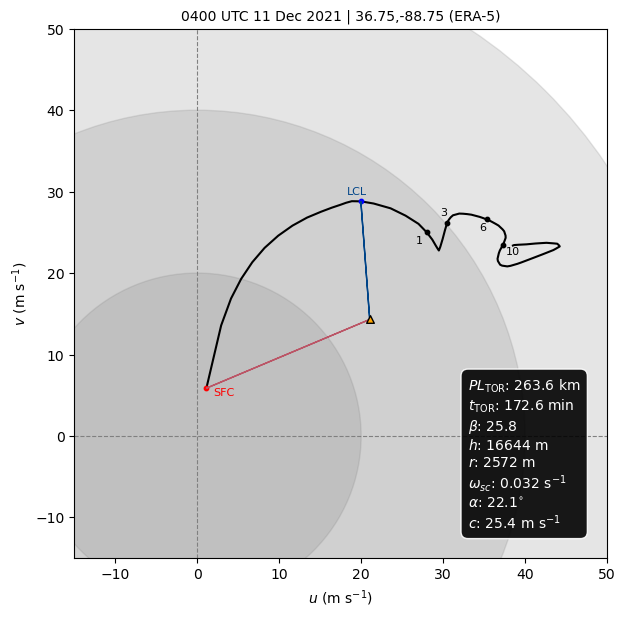

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming calc_tor_path is a predefined function
# Read in CSV profile and calculate tornado parameters
profile = pd.read_csv('ERA5_2021_12_11_0400_36.75_-88.75.csv')
pl_tor, t_tor, c, r, beta, tau, h, hbwd, V_upper, U_lower, omega_sc, alpha, u_agl, v_agl, z_agl, lclh, cu, cv = calc_tor_path(profile)

# Find closest index for MLLCL height
closest_mllcl_idx = (np.abs(z_agl - lclh)).idxmin()

# Create figure and axis
fig, ax = plt.subplots(figsize=(6.875, 6.875))

# Plot hodograph
ax.plot(u_agl, v_agl, linestyle='-', color='k')

# Annotate specific heights
heights = [0, 1000, 3000, 6000, 10000]
offsets = [(5, -5), (-8, -8), (-5, 5), (-5, -8), (2, -7)]  # Example offsets for each height

for height, offset in zip(heights, offsets):
    closest_idx = (np.abs(z_agl - height)).idxmin()
    color = 'red' if height == 0 else 'k'
    label = "SFC" if height == 0 else f"{int(height/1000)}"
    ax.scatter(u_agl[closest_idx], v_agl[closest_idx], color=color, marker='o', s=10, zorder=99)
    ax.annotate(label, (u_agl[closest_idx], v_agl[closest_idx]), xytext=offset, textcoords='offset points',
                ha='left', fontsize=8, color=color)

# Plot storm motion
ax.scatter(cu, cv, color='orange', edgecolor='k', marker='^', s=30, label='Bunkers RM', zorder=499)

# Add storm-relative wind arrows
u_sfc = u_agl[0]
v_sfc = v_agl[0]
ax.arrow(cu, cv, u_sfc - cu, v_sfc - cv, head_width=0, head_length=0, fc='#BB5566', ec='#BB5566', linestyle='-', zorder=201)
ax.arrow(cu, cv, u_agl[closest_mllcl_idx] - cu, v_agl[closest_mllcl_idx] - cv, head_width=0, head_length=0,
         fc='#004488', ec='#004488', linestyle='-', zorder=200)

# Plot MLLCL height
ax.scatter(u_agl[closest_mllcl_idx], v_agl[closest_mllcl_idx], color='blue', marker='o', s=10, zorder=99, label='MLLCL')
ax.annotate("LCL", (u_agl[closest_mllcl_idx], v_agl[closest_mllcl_idx]), xytext=(-10, 5), textcoords='offset points',
            ha='left', fontsize=8, color='#004488')

# Add concentric circles for wind magnitude
for radius in range(70, 10, -10):
    circle = plt.Circle((0, 0), radius, color='grey', alpha=0.2 if radius % 20 == 0 else 0)
    ax.add_patch(circle)

# Set title and labels
ax.set_title("0400 UTC 11 Dec 2021 | 36.75,-88.75 (ERA-5)", fontsize=10)
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')
ax.set_xlim(-15, 50)
ax.set_ylim(-15, 50)
ax.set_yticks(np.arange(-10, 60, 10))
ax.set_xticks(np.arange(-10, 60, 10))
ax.set_ylabel("$v$ (m s$^{-1}$)", fontsize=10)
ax.set_xlabel("$u$ (m s$^{-1}$)", fontsize=10)

# Define the text content with dynamic variables
text_content = (
    f"$PL_{{\\text{{TOR}}}}$: {pl_tor:.1f} km\n"
    f"$t_{{\\text{{TOR}}}}$: {t_tor:.1f} min\n"
    f"$\\beta$: {beta:.1f}\n"
    f"$h$: {h:.0f} m\n"
    f"$r$: {r:.0f} m\n"
    f"$\\omega_{{sc}}$: {omega_sc:.3f} s$^{{-1}}$\n"
    f"$\\alpha$: {np.rad2deg(alpha):.1f}$^{{\\circ}}$\n"
    f"$c$: {c:.1f} m s$^{{-1}}$"
)
# Add the text box with white text and black background
ax.text(
    0.95, 0.05, text_content,
    transform=ax.transAxes,
    fontsize=10,
    color='white',  # Set text color to white
    verticalalignment='bottom',
    horizontalalignment='right',
    multialignment='left',
    bbox=dict(
        boxstyle='round,pad=0.5',
        edgecolor='white',  # Border color
        facecolor='black',  # Background color
        alpha=0.9
    )
)

plt.show()
